# Tutorial - Using `timeseries` APIs

> Using `Datasets` and `DataBlock`

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from fastai2.basics import *

In [3]:
from timeseries.all import *

# Tutorial on timeseries module for fastai v2

## Example : NATOS dataset

<img src="images/NATOPS.jpg">

## Right Arm vs Left Arm (3: 'Not clear' Command (see picture here above))
<br>
<img src="images/ts-right-arm.png"><img src="images/ts-left-arm.png">

## Description
The data is generated by sensors on the hands, elbows, wrists and thumbs. The data are the x,y,z coordinates for each of the eight locations. The order of the data is as follows:

## Channels (24)
0.	Hand tip left, X coordinate
1.	Hand tip left, Y coordinate
2.	Hand tip left, Z coordinate
3.	Hand tip right, X coordinate
4.	Hand tip right, Y coordinate
5.	Hand tip right, Z coordinate
6.	Elbow left, X coordinate
7.	Elbow left, Y coordinate
8.	Elbow left, Z coordinate
9.	Elbow right, X coordinate
10.	Elbow right, Y coordinate
11.	Elbow right, Z coordinate
12.	Wrist left, X coordinate
13.	Wrist left, Y coordinate
14.	Wrist left, Z coordinate
15.	Wrist right, X coordinate
16.	Wrist right, Y coordinate
17.	Wrist right, Z coordinate
18.	Thumb left, X coordinate
19.	Thumb left, Y coordinate
20.	Thumb left, Z coordinate
21.	Thumb right, X coordinate
22.	Thumb right, Y coordinate
23.	Thumb right, Z coordinate

## Classes (6)
The six classes are separate actions, with the following meaning:
 
1: I have command 
2: All clear 
3: Not clear 
4: Spread wings 
5: Fold wings 
6: Lock wings

## Download data using `download_unzip_data_UCR(dsname=dsname)` method

In [4]:
# path_data = Config().data
# path_data, path_data.ls()

In [5]:
dsname =  'NATOPS' #'NATOPS', 'LSST', 'Wine', 'Epilepsy', 'HandMovementDirection'

In [6]:
path = download_unzip_data_UCR(dsname=dsname)
path.ls()

(#55) [Path('C:/Users/fh/.fastai/data/NATOPS/models'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS.jpg'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS.txt'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension10_TEST.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension10_TRAIN.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension11_TEST.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension11_TRAIN.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension12_TEST.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension12_TRAIN.arff'),Path('C:/Users/fh/.fastai/data/NATOPS/NATOPSDimension13_TEST.arff')...]

## Why do I have to concatenate train and test data?
Both Train and Train dataset contains 180 samples each. We concatenate them in order to have one big dataset and then split into train and valid dataset using our own split percentage (20%, 30%, or whatever number you see fit)

In [7]:
fname_train = path/f'{dsname}_Train.arff'
fname_test = path/f'{dsname}_Test.arff'
fnames = [fname_train, fname_test]
fnames

[Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Train.arff'),
 Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Test.arff')]

In [8]:
data = TSData()
train_x, train_y = data.load([fname_train, fname_test])
print(data)

TSData:
 Datasets names (concatenated): ['NATOPS_Train', 'NATOPS_Test']
 Filenames: \                   [Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Train.arff'), Path('C:/Users/fh/.fastai/data/NATOPS/NATOPS_Test.arff')]
 Data shape: (360, 24, 51)
 Targets shape: (360,)
 Nb Samples: 360
 Nb Channels: \         24
 Sequence Length: 51


In [9]:
items = data.get_items()

In [10]:
idx = 1
x1, y1 = data.x[idx],  data.y[idx]
y1

'3.0'

In [11]:

# You can select any channel to display buy supplying a list of channels and pass it to `chs` argument
# LEFT ARM
# show_timeseries(x1, title=y1, chs=[0,1,2,6,7,8,12,13,14,18,19,20])


In [12]:
# RIGHT ARM
# show_timeseries(x1, title=y1, chs=[3,4,5,9,10,11,15,16,17,21,22,23])

In [13]:
?show_timeseries(x1, title=y1, chs=range(0,24,3)) # Only the x axis coordinates


Object `show_timeseries(x1, title=y1, chs=range(0,24,3)) # Only the x axis coordinates` not found.


In [14]:
seed = 42
splits = RandomSplitter(seed=seed)(range_of(items)) #by default 80% for train split and 20% for valid split are chosen 
splits

((#288) [304,281,114,329,115,130,338,294,94,310...],
 (#72) [222,27,96,253,274,35,160,172,302,146...])

# Using `Datasets` class

## Creating a Datasets object

In [15]:
tfms = [[ToTensorTS(as_item=True)], [LabelTS(as_item=True), Categorize()]]
# Create a dataset
ds = Datasets(items, tfms, splits=splits)

3.0


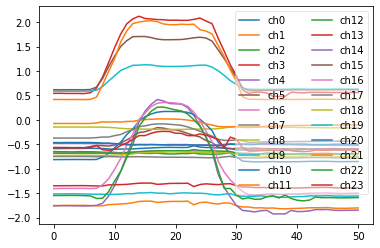

In [16]:
ax = show_at(ds, 2, figsize=(1,1))

# Create a `Dataloader` objects

## 1st method : using `Datasets` object

In [17]:
bs = 128                            
# Normalize at batch time
tfm_norm = Normalize(scale_subtype = 'per_sample_per_channel', scale_range=(0, 1)) # per_sample , per_sample_per_channel
# tfm_norm = Standardize(scale_subtype = 'per_sample')
batch_tfms = [tfm_norm]

dls_1 = ds.dataloaders( bs=bs, val_bs=bs * 2, after_batch=batch_tfms, num_workers=0, device=default_device()) 

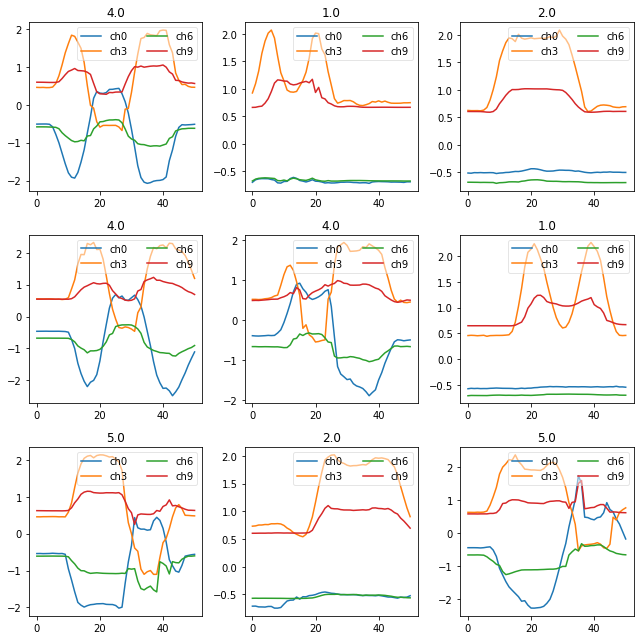

In [18]:
dls_1.show_batch(ctxs=None, max_n=9, chs=range(0,12,3))

# Using `DataBlock` class

## 2nd method : using `DataBlock` and `DataBlock.get_items()` 

In [19]:
tsdb = DataBlock(blocks=(TSBlock, CategoryBlock),
                   get_items=get_ts_items,
                   get_x=lambda x:x[0],
                   splitter=RandomSplitter(seed=seed),
                   get_y=lambda x:x[1],
                   batch_tfms = batch_tfms)

In [21]:
tsdb.summary([fname_train, fname_test])

Setting-up type transforms pipelines
Found 360 items
2 datasets of sizes 288,72
Setting up Pipeline: <lambda> -> ToTensorTSBlock
Setting up Pipeline: <lambda> -> Categorize

Building one sample
  Pipeline: <lambda> -> ToTensorTSBlock
    starting from
      ([[-0.540579 -0.54101  -0.540603 ... -0.56305  -0.566314 -0.553712]
 [-1.539567 -1.540042 -1.538992 ... -1.532014 -1.534645 -1.536015]
 [-0.608539 -0.604609 -0.607679 ... -0.593769 -0.592854 -0.599014]
 ...
 [ 0.454542  0.449924  0.453195 ...  0.480281  0.45537   0.457275]
 [-1.411445 -1.363464 -1.390869 ... -1.468123 -1.368706 -1.386574]
 [-0.473406 -0.453322 -0.463813 ... -0.440582 -0.427211 -0.435581]], 2.0)
    applying <lambda> gives
      [[-0.540579 -0.54101  -0.540603 ... -0.56305  -0.566314 -0.553712]
 [-1.539567 -1.540042 -1.538992 ... -1.532014 -1.534645 -1.536015]
 [-0.608539 -0.604609 -0.607679 ... -0.593769 -0.592854 -0.599014]
 ...
 [ 0.454542  0.449924  0.453195 ...  0.480281  0.45537   0.457275]
 [-1.411445 -1.36346

In [20]:
dls_2 = tsdb.dataloaders([fname_train, fname_test], num_workers=0, device=default_device())

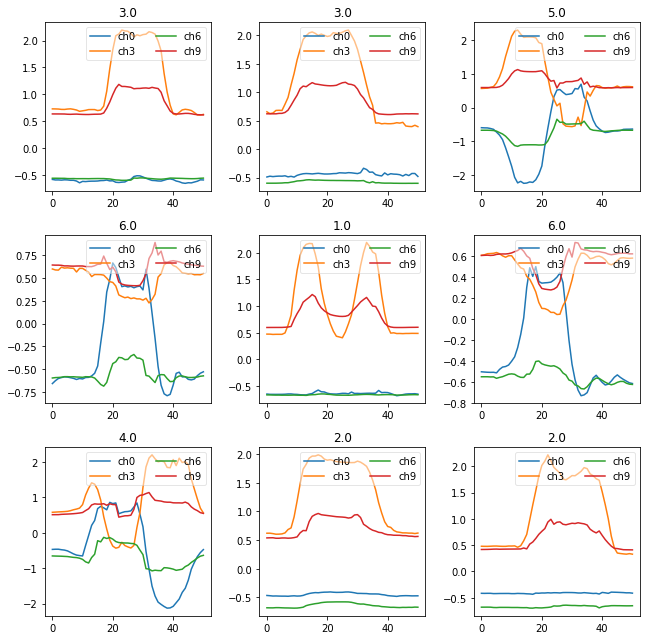

In [22]:
dls_2.show_batch(ctxs=None, max_n=9, chs=range(0,12,3))

## 3rd method : using `DataBlock` and passing `items` object to the `DataBlock.dataloaders()`

In [23]:
tsdb_3 = DataBlock(blocks=(TSBlock, CategoryBlock),
                   get_x=lambda x:x[0],
                   splitter=RandomSplitter(seed=seed),
                   get_y=lambda x:x[1])

In [35]:
dls_3 = tsdb_3.dataloaders(data.get_items(), batch_tfms=batch_tfms, num_workers=0, device=default_device())

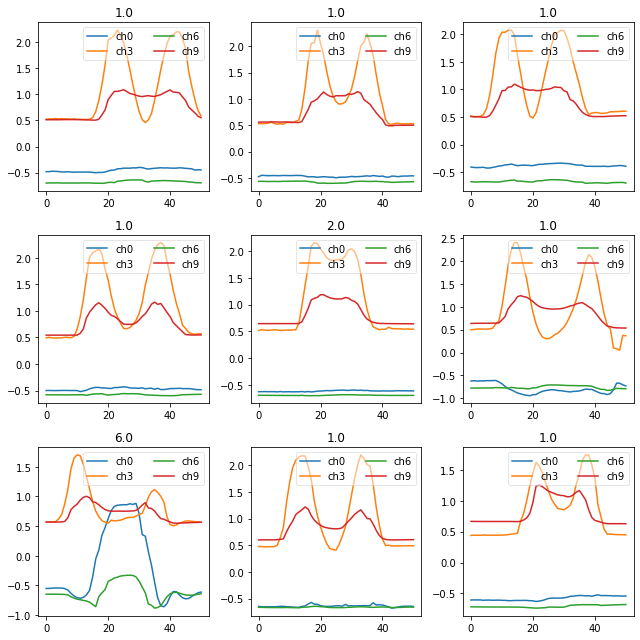

In [36]:
dls_3.show_batch(ctxs=None, max_n=9, chs=range(0,12,3))

## 4th method : using `TSDataLoaders` class and `TSDataLoaders.from_files()`

In [37]:
dls_4 = TSDataLoaders.from_files(fnames=[fname_train, fname_test], batch_tfms=batch_tfms, num_workers=0, device=default_device())

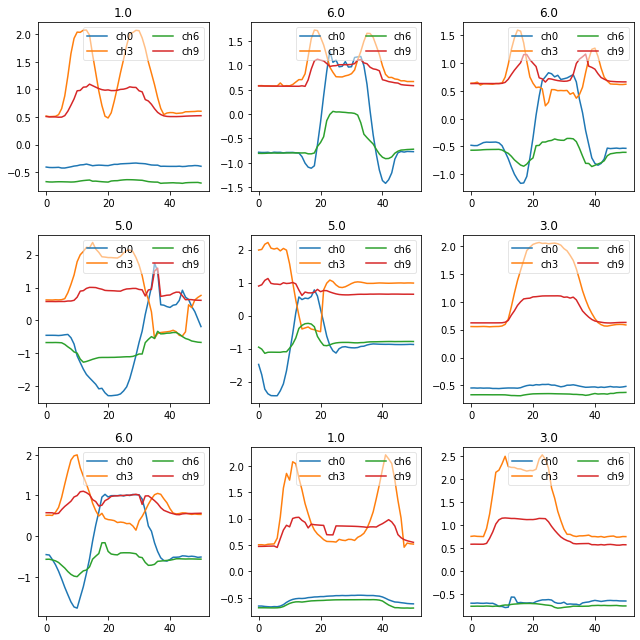

In [38]:
dls_4.show_batch(ctxs=None, max_n=9, chs=range(0,12,3))

# Train Model

In [39]:
# Number of channels (i.e. dimensions in ARFF and TS files jargon)
c_in = get_n_channels(dls_4.train) # data.n_channels
# Number of classes
c_out= len(dls_4.vocab) 
c_in,c_out

(24, 6)

## Create model

In [40]:
model = create_inception(c_in, c_out).to(device=default_device())
model

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(24, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(24, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(24, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxpool_bottleneck): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(24, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (bn_relu): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
        )
      )
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39

## Create Learner object

In [41]:
#Learner
opt_func = partial(Adam, lr=3e-3, wd=0.01)     
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls_4, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)

print(learn.summary())

Sequential (Input shape: ['64 x 24 x 51'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               64 x 32 x 51         29,952     True      
________________________________________________________________
Conv1d               64 x 32 x 51         14,592     True      
________________________________________________________________
Conv1d               64 x 32 x 51         6,912      True      
________________________________________________________________
MaxPool1d            64 x 24 x 51         0          False     
________________________________________________________________
Conv1d               64 x 32 x 51         768        True      
________________________________________________________________
BatchNorm1d          64 x 128 x 51        256        True      
________________________________________________________________
ReLU                 64 x 128 x 51        0          False     
_______________________________________________________

## LR find 

(0.00831763744354248, 0.0002290867705596611)

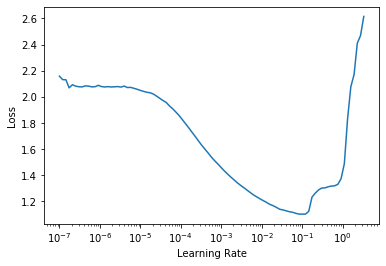

In [42]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

## Train

In [51]:
#lr_max=1e-3
epochs=20; lr_max=lr_steep;  pct_start=.7; moms=(0.95,0.85,0.95); wd=1e-2
learn.fit_one_cycle(epochs, lr_max=lr_max, pct_start=pct_start,  moms=moms, wd=wd)
# learn.fit_one_cycle(epochs=20, lr_max=lr_steep)
learn.save('stage_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.453057,0.582527,0.958333,00:00
1,0.455297,0.577670,0.930556,00:00
2,0.455172,0.585421,0.916667,00:00
3,0.455005,0.591815,0.902778,00:00
4,0.453862,0.576485,0.916667,00:00
5,0.453960,0.573440,0.916667,00:00
6,0.452723,0.616046,0.888889,00:00
7,0.451592,0.556821,0.916667,00:00
8,0.450404,0.563121,0.958333,00:00
9,0.450158,0.549011,0.944444,00:00


## Plot loss function

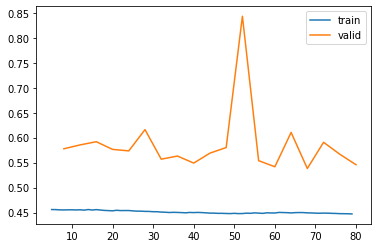

In [52]:
learn.recorder.plot_loss()

## Show results

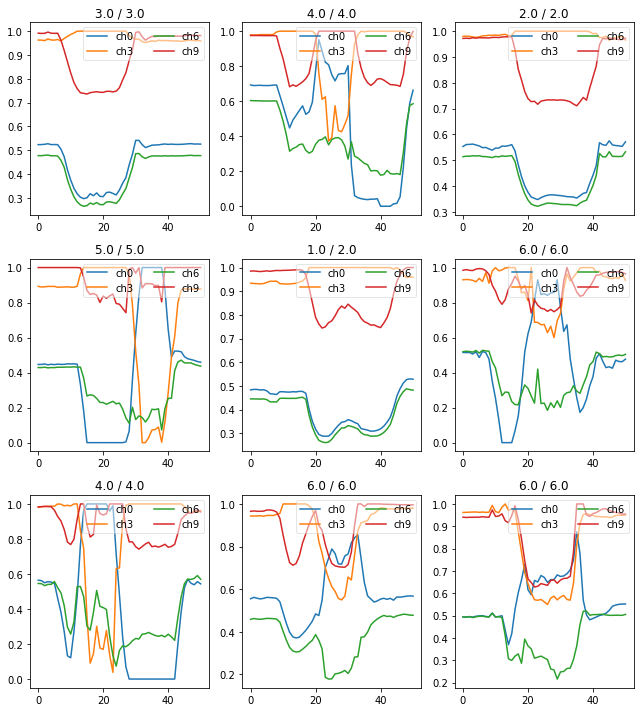

In [53]:
learn.show_results(max_n=9, chs=range(0,12,3))

In [54]:
#hide
from nbdev.export import notebook2script
notebook2script()
# notebook2script(fname='index.ipynb')

Converted 80_timeseries_data.ipynb.
Converted 81_timeseries_core.ipynb.
Converted index.ipynb.


In [49]:
#hide
from nbdev.export2html import _notebook2html
# notebook2script()
_notebook2html(fname='index.ipynb')

converting: index.ipynb
'charmap' codec can't encode character '\u2212' in position 26371: character maps to <undefined>


False

# Fin

<img src="images/tree.jpg" width="1440" height="840" alt=""/>